In [26]:
#----------------------------------  Import --------------------------------------------
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#----------------------------------  Data load --------------------------------------------
features_path = 'C:\\Users\\USER\\Desktop\\이소현\\EEG\\B2X_2nd_Year_3rd_Pilot_Customizing\\python\\features\\features.mat'
features = scipy.io.loadmat(features_path)['features']

features

array([[(array([[1.2195122]]), array([[1.2195122]]), array([[12.19512195]]), array([[20.87038981]]), array([[40.3]]), array([[0.384]]), array([[0.616]]), array([[0.624]]), array(['S0'], dtype='<U2'), array(['base'], dtype='<U4'), array([[array(['20211113_KDH'], dtype='<U12')]], dtype=object), array([[0.25607997]], dtype=float32), array([[0.1564137]], dtype=float32), array([[0.11321405]], dtype=float32), array([[0.20237133]], dtype=float32), array([[0.2719209]], dtype=float32), array([[0.23884168]], dtype=float32), array([[0.20532793]], dtype=float32), array([[0.11015749]], dtype=float32), array([[0.18967499]], dtype=float32), array([[0.25599787]], dtype=float32), array([[0.20956424]], dtype=float32), array([[0.0853837]], dtype=float32), array([[0.13906777]], dtype=float32), array([[0.24233688]], dtype=float32), array([[0.32364732]], dtype=float32), array([[0.1106717]], dtype=float32), array([[0.16324078]], dtype=float32), array([[0.1626344]], dtype=float32), array([[0.31240463]], dtype

In [4]:
#---------------------------------- Data preprocessing ------------------------------------
name = features.dtype.names

# Squeeze dimensions
features_squeezed = {n: np.squeeze(features[n]) for n in name}

for i in range(len(features_squeezed['pNN50'])):
    for j in name:
        features_squeezed[j][i] = np.squeeze(features_squeezed[j][i])

df = pd.DataFrame(features_squeezed)
features_df = df[df['name'] != '20220204_PBJ']

exception = ['name', 'stim', 'session']

feature_name = np.setdiff1d(name, exception)

features_df2 = features_df[feature_name]

df2 = features_df2.applymap(pd.to_numeric)

C:\Users\USER\AppData\Local\Temp\ipykernel_22048\921428728.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = features_df2.applymap(pd.to_numeric)


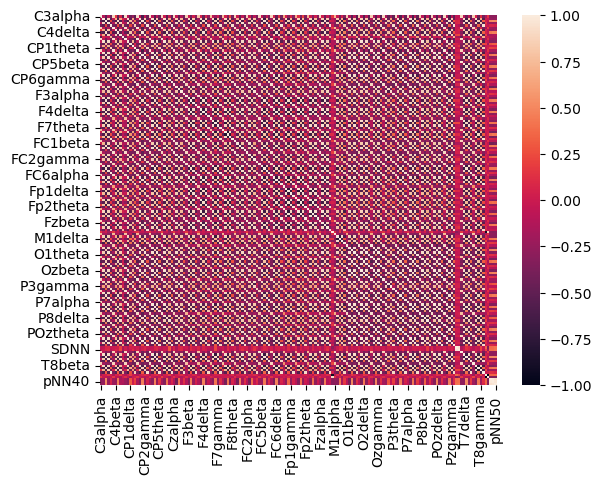

In [5]:
#---------------------------------- Correlation ------------------------------------
plt.figure()
cor = df2.corr()
sns.heatmap(cor)
plt.show()

In [6]:
# Check features over 0.9 corr
print(cor.shape)
columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if cor.iloc[i,j] >= 0.9:
            if columns[j]:
                print(df2.columns[j])
                print(df2.columns[i])
                print(cor.iloc[i, j])
                columns[j] = False


# Selected features list
selected_columns = df2.columns[columns]

selected_df = df2[selected_columns]

df2.shape[1]

(163, 163)
CP1alpha
C3alpha
0.922177872642948
CP2alpha
C3alpha
0.919236944528849
CP5alpha
C3alpha
0.9197593063280715
P3alpha
C3alpha
0.9020863321622792
Pzalpha
C3alpha
0.9083685462077534
CP1beta
C3beta
0.9300202294483109
CP2beta
C3beta
0.9366886248508604
CP5beta
C3beta
0.9442613701670114
CP6beta
C3beta
0.9274381513513753
F3beta
C3beta
0.9123498641278424
F4beta
C3beta
0.9218271216202828
F7beta
C3beta
0.9291203718517763
FC5beta
C3beta
0.9400053808687001
FC6beta
C3beta
0.9303138885338063
P4beta
C3beta
0.917293482492274
P7beta
C3beta
0.9224560176250546
POzbeta
C3beta
0.9023857882267634
Pzbeta
C3beta
0.9207935115479255
T7beta
C3beta
0.9289395887932875
C4delta
C3delta
0.9427189587381338
CP2delta
C3delta
0.9510443225886444
CP5delta
C3delta
0.9683136773047759
CP6delta
C3delta
0.9002871197518991
F3delta
C3delta
0.9460816026172936
F4delta
C3delta
0.922892327904408
FC1delta
C3delta
0.9289594365092576
FC5delta
C3delta
0.9595657515857268
FC6delta
C3delta
0.9088286958956548
Fzdelta
C3delta
0.9342149

163

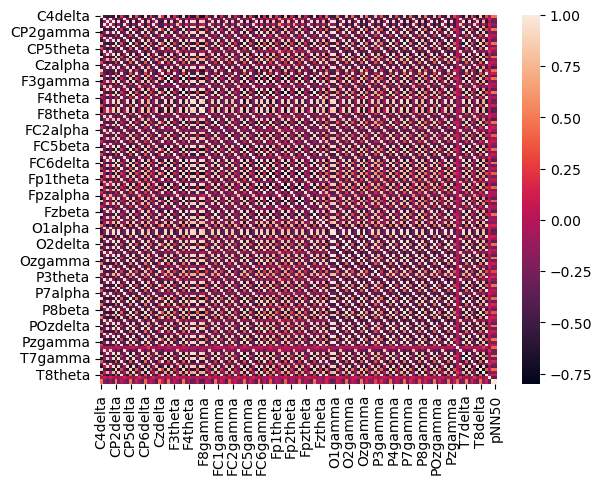

In [7]:
# Check banned features
check = df2.columns[~columns]
plt.figure()
cor = df2[check].corr()
sns.heatmap(cor)
plt.show()

In [8]:
#----------------------------------  Import --------------------------------------------
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix      
from sklearn.decomposition import PCA

In [10]:
#----------------------------------K-means clustering------------------------------------
## input
# data  - dataframe
# k     - the number of clusters
## output
# silhouette score

def k_means_modeling(data, k):
    model = KMeans(n_clusters = k, random_state = 5, n_init = "auto").fit(data)
    pyLabels = model.labels_
    print(f"The K-means silhouette score with {k} clusters is {silhouette_score(data, pyLabels, metric='euclidean')}")

    return silhouette_score(data, pyLabels, metric = 'euclidean'), model

In [130]:
#----------------------------------  main --------------------------------------------
# feature들을 여러개로 나누고 for문
# 각 feature마다 k를 다양하게 하여 for문
# 가장 높은 silhoutte score를 가진 feature 조합, k 내놓기 - elbow는 사람이 직접 그래프를 보고 k를 정해야해서 벤
# backward selection
# 나온 feature들에 대해 중요도를 매긴 후에 순차적으로 제거해야함 - 그래서 보류
iteration_log = ""
last_eleminated = ""
cols = selected_df.columns.tolist() # corr 하고나서 뽑힌 column name list

feature_list = []
data = selected_df


for i in range(selected_df.shape[1]):
    for k in range(2, 15):
        if i != 0: #elimination 시작
            new_criteria, new_model = k_means_modeling(data, k)
            if criteria < new_criteria:
                print("Regained : ", last_eleminated)
                iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                break  

        else: #feature 전체 다 씀
            criteria, model = k_means_modeling(data, k)
            iteration_log += "\n"+str(model.summary())+"\nSilhouette score: "+ str(new_criteria) + "\n"
        
        cols = data.columns.tolist()# 현재 돌고있는 cycle의 feature list
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break

The K-means silhouette score with 2 clusters is 0.8180697575737634


c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'KMeans' object has no attribute 'summary'

In [11]:
# K-means without backward elimination
kmeans_silhouette= []
data = selected_df
best_k = 1

print("***********K-means**************")
for k in range(2, 15):
    new_criteria, new_model = k_means_modeling(data, k)
    kmeans_silhouette.append(new_criteria)
    if(new_criteria == max(kmeans_silhouette)):
        best_model = new_model
        best_k = k


***********K-means**************
The K-means silhouette score with 2 clusters is 0.8180697575737634
The K-means silhouette score with 3 clusters is 0.5865883217013951
The K-means silhouette score with 4 clusters is 0.5721566614284137
The K-means silhouette score with 5 clusters is 0.6701818235213397
The K-means silhouette score with 6 clusters is 0.526694589513416
The K-means silhouette score with 7 clusters is 0.5266329900417129
The K-means silhouette score with 8 clusters is 0.4380150634951826
The K-means silhouette score with 9 clusters is 0.39573635447609284
The K-means silhouette score with 10 clusters is 0.40077485464128043
The K-means silhouette score with 11 clusters is 0.37631245505175304
The K-means silhouette score with 12 clusters is 0.4063673522393211
The K-means silhouette score with 13 clusters is 0.3787937612330094
The K-means silhouette score with 14 clusters is 0.3639878085865463


c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known

c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


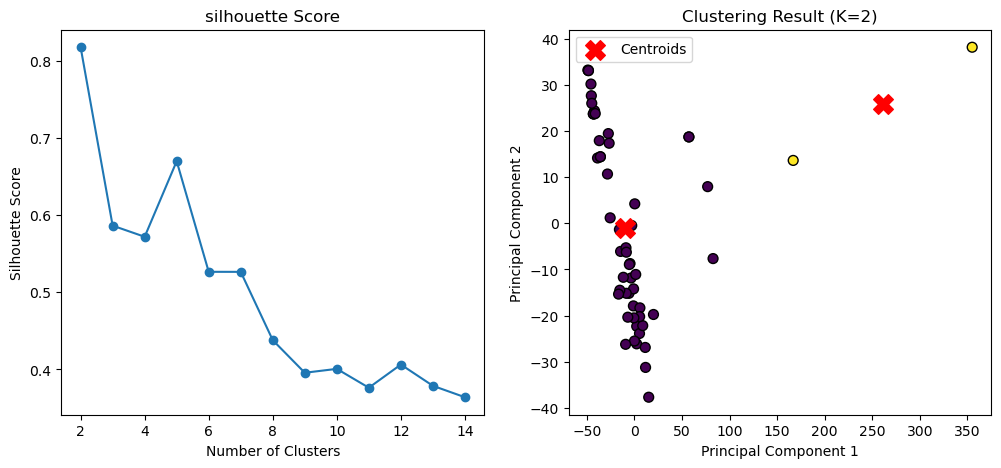

,name,session,stim
11,['20211230_CJK'],reco,N020
25,['20220125_KMS'],reco,S0


In [12]:
# ----------------------- plotting -----------------------------------
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

n_clusters = range(2, 15)
axs[0].set_title('silhouette Score')
axs[0].plot(n_clusters, kmeans_silhouette, marker='o')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Scatter plot
# use PCA to plot the clutering result
best_n_clusters = best_k  # 예시로 4개의 클러스터를 사용
labels = best_model.labels_

pca = PCA(n_components = 2) # 2D로 나타내기 위해 우선은 2로
reduced_X = pca.fit_transform(selected_df)

axs[1].set_title(f'Clustering Result (K={best_n_clusters})')
axs[1].scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
axs[1].scatter(pca.transform(best_model.cluster_centers_)[:, 0], pca.transform(best_model.cluster_centers_)[:, 1],
            marker='X', s=200, color='red', label='Centroids')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].legend()
plt.show()

non_zero_idx = np.nonzero(labels)
pd.set_option('display.max_columns', None)
features_df.iloc[non_zero_idx][['name', 'session', 'stim']]

In [25]:
from sklearn.mixture import GaussianMixture
def gaussianMixture_modeling(data, k):
    gmm = GaussianMixture(n_components = k)
    labels = gmm.fit_predict(data)
    print(f"The EM(GMM) silhouette score with {k} clusters is {silhouette_score(data, labels, metric='euclidean')}")

    return silhouette_score(data, labels, metric = 'euclidean'), gmm

In [23]:
# GaussianMixture without backward elimination
gaussian_mixture_silhouette= []
data = selected_df
best_k = 1

print("***********K-means**************")
for k in range(2, 15):
    new_criteria, new_model = gaussianMixture_modeling(data, k)
    gaussian_mixture_silhouette.append(new_criteria)
    if(new_criteria == max(gaussian_mixture_silhouette)):
        best_model = new_model
        best_k = k

***********K-means**************
The EM(GMM) silhouette score with 2 clusters is 0.7025163341436279
The EM(GMM) silhouette score with 3 clusters is 0.5429752780956223
The EM(GMM) silhouette score with 4 clusters is 0.5964489868997672
The EM(GMM) silhouette score with 5 clusters is 0.6701818235213397
The EM(GMM) silhouette score with 6 clusters is 0.5258853652064097
The EM(GMM) silhouette score with 7 clusters is 0.4895110910761544
The EM(GMM) silhouette score with 8 clusters is 0.4323005330840354
The EM(GMM) silhouette score with 9 clusters is 0.43569881918783665
The EM(GMM) silhouette score with 10 clusters is 0.41597823994702604
The EM(GMM) silhouette score with 11 clusters is 0.41391185834625166
The EM(GMM) silhouette score with 12 clusters is 0.3830626347307999
The EM(GMM) silhouette score with 13 clusters is 0.4112927791707578
The EM(GMM) silhouette score with 14 clusters is 0.37241277663603956


c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known

c:\Users\USER\anaconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


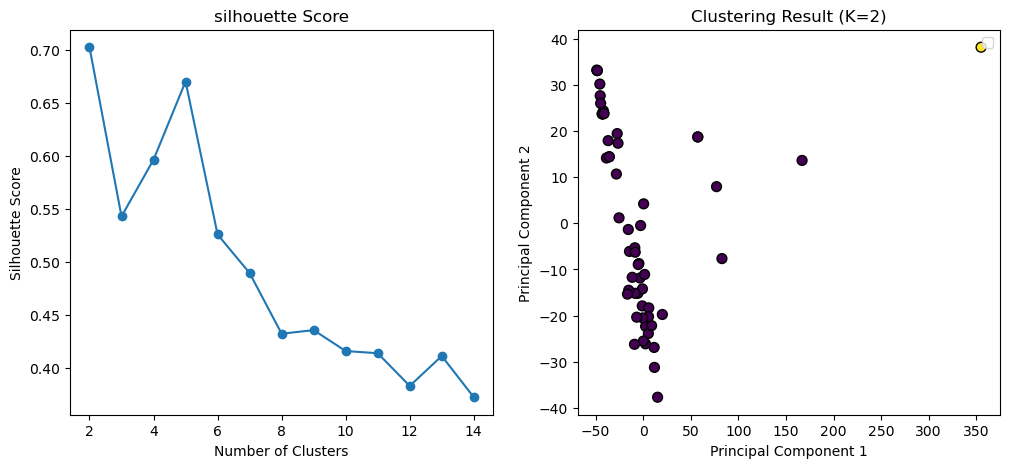

,name,session,stim
25,['20220125_KMS'],reco,S0


In [24]:
# ----------------------- plotting -----------------------------------
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

n_clusters = range(2, 15)
axs[0].set_title('silhouette Score')
axs[0].plot(n_clusters, gaussian_mixture_silhouette, marker='o')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Scatter plot
# use PCA to plot the clutering result
best_n_clusters = best_k  # 예시로 4개의 클러스터를 사용
labels = best_model.fit_predict(selected_df)

pca = PCA(n_components = 2) # 2D로 나타내기 위해 우선은 2로
reduced_X = pca.fit_transform(selected_df)

axs[1].set_title(f'Clustering Result (K={best_n_clusters})')
axs[1].scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].legend()
plt.show()

non_zero_idx = np.nonzero(labels)
pd.set_option('display.max_columns', None)
features_df.iloc[non_zero_idx][['name', 'session', 'stim']]